## Long Short-Term Memory (LSTMs)

In [5]:
# Import all required libraries
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [6]:
# Import feature and target columns
df = pickle.load(open("../../common/df.p", "rb"))

### Perform Cross Validation

### Train the model

In [7]:
def smape(y_true, y_pred):
    return 100/len(y_true) * np.sum(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))

In [8]:
# Use MinMaxScaler to normalize the data to between 0 and 1
feature_scaler = MinMaxScaler(feature_range=(0, 1))
scaled_df = feature_scaler.fit_transform(df)
# scaled_df = feature_scaler.fit_transform(df[['tps']])

# Target scaler (only for 'tps')
target_scaler = MinMaxScaler(feature_range=(0, 1))
scaled_tps = target_scaler.fit_transform(df[['tps']])  # double brackets to keep it as DataFrame

X = []  # inputs
y = []  # outputs (the 'tps' column)

n_future = 1  # number of time steps to predict into the future
n_past = 10  # number of past time steps to use as inputs

# For each timestep
for i in range(n_past, len(scaled_df) - n_future +1):
    X.append(scaled_df[i - n_past:i, :])  # append past 'n_past' records including all variables
    y.append(scaled_tps[i + n_future - 1:i + n_future, 0])  # append 'n_future' ahead 'tps' variable

# Convert to numpy arrays for use with the LSTM model
X, y = np.array(X), np.array(y)

# Splitting data into 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

# Designing the LSTM model
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dense(y_train.shape[1]))

model.compile(optimizer='adam', loss='mse')

# fit the model
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

# Predict future tps on test data
yhat = model.predict(X_test)
yhat = target_scaler.inverse_transform(yhat)  # use the target_scaler to re-transform to the original scale

# also inverse transform the actual test data for comparison
y_test = target_scaler.inverse_transform(y_test)

# print the first prediction and corresponding actual value
print(f'First test prediction: {yhat[0][0]}, actual value: {y_test[0][0]}')

# find and print the SMAPE error
smape_value = smape(y_test, yhat)
print(f'SMAPE: {smape_value}%')

Epoch 1/50
43/43 [==============================] - 6s 26ms/step - loss: 0.0374 - val_loss: 0.0038
Epoch 2/50
43/43 [==============================] - 0s 10ms/step - loss: 0.0077 - val_loss: 0.0021
Epoch 3/50
43/43 [==============================] - 0s 11ms/step - loss: 0.0049 - val_loss: 9.3685e-04
Epoch 4/50
43/43 [==============================] - 1s 12ms/step - loss: 0.0031 - val_loss: 6.5162e-04
Epoch 5/50
43/43 [==============================] - 1s 12ms/step - loss: 0.0019 - val_loss: 7.8216e-04
Epoch 6/50
43/43 [==============================] - 0s 11ms/step - loss: 0.0017 - val_loss: 0.0016
Epoch 7/50
43/43 [==============================] - 0s 9ms/step - loss: 0.0016 - val_loss: 9.8731e-04
Epoch 8/50
43/43 [==============================] - 0s 10ms/step - loss: 0.0011 - val_loss: 8.2331e-04
Epoch 9/50
43/43 [==============================] - 0s 10ms/step - loss: 0.0011 - val_loss: 0.0015
Epoch 10/50
43/43 [==============================] - 0s 10ms/step - loss: 0.0013 - val_los

### Visualize the model

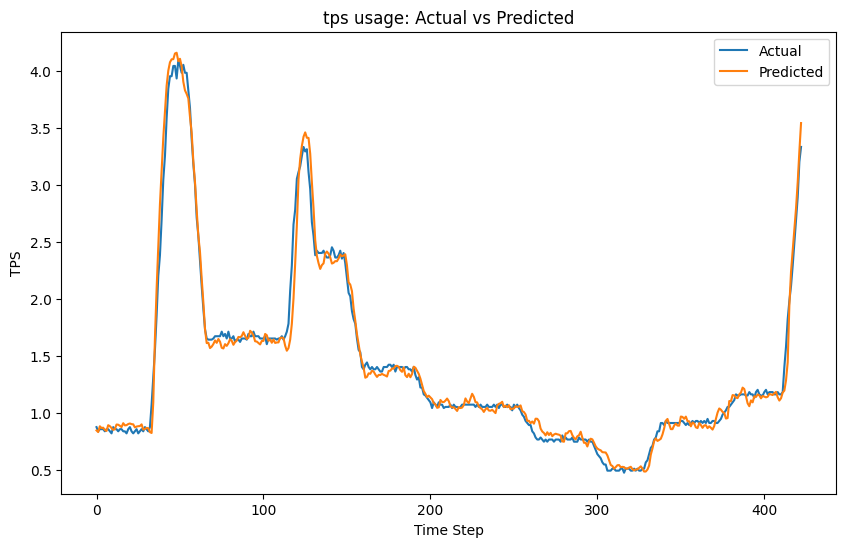

In [9]:
# Plot actual vs predicted
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual')
plt.plot(yhat, label='Predicted')
plt.title('tps usage: Actual vs Predicted')
plt.ylabel('TPS')
plt.xlabel('Time Step')
plt.legend()
plt.show()

### Export the model

In [10]:
pickle.dump(model, open('../../models/multivariate/lstm/tps.p', 'wb'))